In [1]:
import os
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

In [2]:
def RSME(cvresult,key):
    return (abs(cvresult[key])**0.5).mean()

In [3]:
BAST_PATH = "E:/download/"
filename = "train_encode.csv"
file = os.path.join(BAST_PATH,filename)

df = pd.read_csv(file)

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [5]:
X.head()

,Unnamed: 0,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [6]:
reg = RFR(random_state=1412)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

result_pre_adjusted = cross_validate(reg,X,y,cv=cv,scoring="neg_mean_squared_error",
                                    return_train_score=True,
                                    verbose=True,
                                    n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


In [7]:
RSME(result_pre_adjusted,"train_score")

11230.897867519101

In [8]:
RSME(result_pre_adjusted,"test_score")

30490.094461014414

In [9]:
param_grid_simple = {"criterion": ["squared_error","poisson"]
                     , 'n_estimators': [*range(20,100,5)]
                     , 'max_depth': [*range(10,25,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                     , "min_impurity_decrease": [*np.arange(0,5,10)]
                    }

In [10]:
#n_jobs=4/8,verbose=True
reg = RFR(random_state=1412,verbose=True,n_jobs=-1)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)
search = GridSearchCV(estimator=reg
                     ,param_grid=param_grid_simple
                     ,scoring = "neg_mean_squared_error"
                     ,verbose = True
                     ,cv = cv
                     ,n_jobs=-1)

In [11]:
start = time.time()
search.fit(X,y)
print(time.time()-start)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


C:\Users\WenBi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan ... -3.41839031e+09
 -3.40284841e+09 -3.40005980e+09]
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


554.756801366806


[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    0.1s finished


In [12]:
search.best_estimator_

RandomForestRegressor(criterion='poisson', max_depth=24, max_features='log2',
                      min_impurity_decrease=0, n_estimators=95, n_jobs=-1,
                      random_state=1412, verbose=True)

In [13]:
abs(search.best_score_)**0.5

46489.499658639485

In [15]:
ad_reg = RFR(n_estimators=95,max_depth=24,random_state=1412)

In [16]:
cv = KFold(n_splits=5,shuffle=True,random_state=1412)
result_post_adjusted = cross_validate(ad_reg,X,y,cv=cv,scoring="neg_mean_squared_error",
                                    return_train_score=True,
                                    verbose=True,
                                    n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


In [18]:
RSME(result_post_adjusted,"train_score")

11305.631022138565

In [19]:
RSME(result_post_adjusted,"test_score")

30579.77709796423

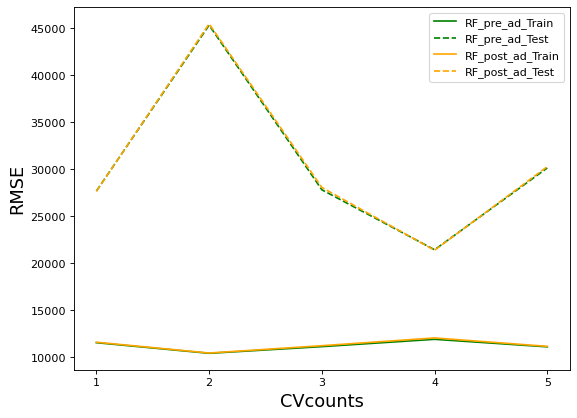

In [20]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

plt.plot(xaxis,abs(result_pre_adjusted["train_score"])**0.5,color="green",label = "RF_pre_ad_Train")
plt.plot(xaxis,abs(result_pre_adjusted["test_score"])**0.5,color="green",linestyle="--",label = "RF_pre_ad_Test")
plt.plot(xaxis,abs(result_post_adjusted["train_score"])**0.5,color="orange",label = "RF_post_ad_Train")
plt.plot(xaxis,abs(result_post_adjusted["test_score"])**0.5,color="orange",linestyle="--",label = "RF_post_ad_Test")
plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.legend()
plt.show()